# **Midterm Project**

## Name: CANOY RAYMART JAY
## Student ID #: 2020021376




## **(00) Setting up**

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Making this notebook's output stable across runs
np.random.seed(42)

# Location for saving the midterm project
PROJECT_ROOT_DIR = '.'
PROJECT_ID = 'midterm'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Saving Figure
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print("Saving figure", fid_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#### **Functions that will be used in the analysis**

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.stats import shapiro
from joblib import dump, load



# Normality Test
def normality_test(data):
  shapiro_test = shapiro(data);
  if shapiro_test[1] >= 0.05:
    print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the data was drawn from a normal distribution.'.format(round(shapiro_test[1], 5)))
  else:
    print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the data MAY NOT be drawn from a normal distribution'.format(round(shapiro_test[1], 5)))
    print('-'*130)
    print('Testing for lognormality . . .')
    logNorm_shapiro_test = shapiro(np.log(data))
    if logNorm_shapiro_test[1] >= 0.05:
      print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the log(data) was drawn from a normal distribution.'.format(round(logNorm_shapiro_test[1], 5)))
    else:
      print('Using Shapiro-Wilky Test, the p-value is {}. Therefore, the log(data) MAY NOT be drawn from a normal distribution'.format(round(logNorm_shapiro_test[1], 5)))
      print('Try performing an outlier test.')



# Precision, Recall, ROC AUC scores, and FPR and TPR
def precision_recall_auc_scores(model, X, y, model_classes_list, precision_score_list, recall_score_list, roc_auc_score_list, fpr_dict, tpr_dict, random_=False,):
  for class_ in model.classes_:
    model_classes_list.append(class_)
    
    # Precision/Recall and ROC AUC scores
    alzheimers_data_pred_per_class = cross_val_predict(model, X, y==class_, cv=10)
    precision_score_list.append(precision_score(y == class_, alzheimers_data_pred_per_class))
    recall_score_list.append(precision_score(y == class_, alzheimers_data_pred_per_class))
    roc_auc_score_list.append(roc_auc_score(y == class_, alzheimers_data_pred_per_class))

    # ROC Curve
    if random_:
      alzheimers_data_probas = cross_val_predict(model, X, y == class_, cv=10, method="predict_proba")
      alzheimers_data_scores = alzheimers_data_probas[:,1]
    else:
      alzheimers_data_scores = cross_val_predict(model, X, y == class_, cv=10, method="decision_function")
    fpr, tpr, threshold = roc_curve(y == class_, alzheimers_data_scores)
    fpr_dict[class_] = fpr
    tpr_dict[class_] = tpr
  
  return model_classes_list, precision_score_list, recall_score_list, roc_auc_score_list, fpr_dict, tpr_dict


# Plotting ROC curves
def plot_roc_curves_ovr(fpr, tpr, style, label_, lw=2):
  plt.plot(fpr, tpr, style, linewidth=lw, label=label_)
  plt.plot([0, 1], [0, 1], 'k--', linewidth=lw)
  plt.xlabel("False Positive Rate (FPR)", fontsize=16)
  plt.ylabel("True Positive Rate (Recall)", fontsize=16)
  plt.grid("True")
  plt.axis([0, 1, 0, 1])


# Plotting a confusion matrix
def plot_confusion_matrix(conf_mx, model_name):
  plt.figure(figsize=(15, 10))
  plt.matshow(sgd_confusion_matrix, cmap=plt.cm.gray)
  plt.ylabel('Actual Class', fontsize=16)
  plt.xlabel("Predicted Class", fontsize =16)
  plt.title(model_name, fontsize=16)

## **(01) Getting and taking a quick look at the data**




### **Downloading and reading the data**

In [3]:
FILE_ROOT = 'https://raw.githubusercontent.com/rjcanoy03/BRI507/'
FILE_PATH = os.path.join(FILE_ROOT, 'Midterm_Project')
FILE_NAME = 'train_data.csv'

def get_data(file_path=FILE_PATH, filename=FILE_NAME):
  csv_path = os.path.join(file_path, filename)
  print("Downloading and reading", filename)
  return pd.read_csv(csv_path)

* Taking a peek at the top 10 rows of the training dataset

In [4]:
alzheimers_data = get_data()
alzheimers_data.head(10)

,DX_bl,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
0,0,9.00,14.00,27,3295,1760,2957,1975,3270,1871,9504,3219,12683,8167,1956,15106,18296,12517,11914,9771,2024,1221,6627.0,6245,5844,2361,2161,4782,2116,1757.0,723,6714,11308,10841,1669,8168,6690,6040,3858,11530,...,2.098,1.965,2.666,1.690,2.328,2.636,2.159,2.354,2.174,2.331,2.335,1.353,1.757,2.270,2.189,2.099,2.695,2.112,2.537,2.004,2.698,2.445,3.461,2.216,1.004,2.480,2.428,2.234,1.670,3.132,2.467,2.424,2.345,2.914,2.461,2.129,2.519,1.606,2.363,2.864
1,0,5.00,7.00,26,3644,1926,4376,2723,4806,1756,10159,2972,13170,10227,1754,14615,18758,12629,9276,10399,2057,842,NaN,7175,5860,2154,2159,5930,2979,1770.0,761,10683,10900,11519,2544,10561,7039,6141,4148,9033,...,2.719,2.031,2.429,2.204,2.079,2.852,2.367,2.887,2.543,2.395,2.431,1.712,2.034,2.602,2.598,2.246,2.401,2.142,2.574,2.169,2.877,2.602,3.375,2.382,NaN,2.657,2.543,2.348,1.948,3.782,2.440,2.843,2.499,2.695,2.457,2.254,2.269,1.868,2.142,2.679
2,2,16.33,29.33,25,3096,2191,3784,2344,2675,2063,8561,3208,14310,7538,1571,14405,20381,11549,9488,8848,2175,1109,6150.0,6085,5977,1828,1392,5996,3021,1562.0,489,8597,6703,8310,2281,11219,7499,7580,4451,7417,...,2.253,1.891,2.540,1.879,2.279,2.548,2.298,2.861,2.528,2.827,2.234,1.404,1.940,2.285,2.436,1.800,2.940,2.152,2.692,1.756,2.607,2.221,3.703,2.175,1.064,2.058,2.168,2.414,1.885,3.303,2.702,2.617,2.108,2.526,2.151,2.003,2.534,1.996,2.163,2.643
3,1,6.00,9.00,29,3857,2660,3382,2751,3783,2202,9074,2504,11995,10484,1986,13690,20896,15095,10463,11313,2787,935,NaN,7009,7279,1719,2238,5620,2816,1934.0,925,11194,11349,10076,2299,11054,7071,6329,5498,8785,...,2.643,2.158,2.489,1.952,2.289,2.767,2.199,3.184,2.388,2.671,2.179,1.536,2.137,2.539,2.481,2.376,2.736,2.163,2.638,2.185,2.709,2.328,3.924,2.529,NaN,2.663,2.990,2.469,1.922,4.232,2.546,2.937,2.514,2.875,2.837,2.379,2.315,1.954,2.326,2.989
4,0,5.00,8.00,28,3411,1578,2664,2433,3448,1550,7128,2500,9801,7732,1451,13050,17785,10460,8407,8573,1952,874,NaN,5275,6034,2070,1405,3591,2244,1110.0,652,9601,9964,8338,2059,8735,5546,5859,4480,8762,...,2.644,2.128,2.702,2.065,2.597,2.874,2.281,2.128,2.689,2.955,2.370,1.536,1.990,2.545,2.519,2.286,2.839,2.495,2.812,2.104,2.652,2.549,3.105,2.390,NaN,2.483,2.381,2.498,1.981,3.331,2.954,2.825,2.440,2.848,2.447,2.256,2.497,2.052,2.498,2.829
5,0,3.33,5.33,30,3540,1428,3918,2111,3539,1935,6955,3082,10875,8773,1814,15407,20977,11587,10094,9856,1799,836,7960.0,6815,6610,2549,1745,4919,2491,2458.0,682,7869,11311,11582,1899,10270,6044,5178,4267,11255,...,2.056,1.843,2.503,1.696,2.468,2.598,2.156,2.060,2.341,2.497,2.118,1.551,1.653,2.310,2.052,2.068,2.820,2.080,2.431,1.816,2.443,2.084,3.491,1.776,0.999,2.357,2.339,2.195,1.504,3.472,2.927,2.255,2.359,2.828,1.972,1.868,2.326,1.608,2.173,2.861
6,0,3.00,5.00,30,3428,2254,3809,2713,3551,2899,8591,3085,12310,9920,2258,14615,21006,14769,12775,10551,2657,1108,NaN,6977,7956,3550,1909,5770,2996,2026.0,858,9925,12602,11746,2372,13707,7220,6512,5148,10318,...,2.569,2.421,2.641,2.008,2.693,3.077,2.355,2.943,2.765,2.909,2.876,1.614,2.010,2.643,2.518,2.541,3.058,2.617,3.088,2.276,3.010,2.592,3.789,2.678,NaN,2.729,3.027,2.411,2.003,4.282,2.541,3.029,2.619,3.102,2.773,2.485,2.656,2.214,2.392,3.142
7,1,5.00,11.00,27,3960,1412,3344,1360,2559,1753,7071,2739,8755,6926,1539,11174,14527,12024,8034,6700,1587,513,5516.0,4430,4686,2075,1725,5026,1807,1953.0,360,6680,10128,7727,1703,9640,4919,5768,2611,8757,...,1.918,2.026,2.437,1.794,2.021,2.732,1.972,1.999,2.300,2.438,2.056

* The attributes have the following meaning:
  * **DX_bl**: The diagnosis group of the subjects
  * **ADAS11**: Alzheimer's Disease Assessment Scale (11-question version) [range: 0-70]
  * **ADAS13**: Alzheimer's Disease Assessment Scale (13-question version) [range: 0-85]
  * **MMSE**: Mini-Mental State Examination [range: 0-30]
  * **ST\*\*\*CV**: Cortical volume of 70 brain regions
  * **ST\*\*\*TA**: Average thickness of 70 brain regions

---

### **Taking a quick look at the data to see how much data is missing**

In [5]:
ad_info = alzheimers_data.info(verbose=True, null_counts=True)
# verbose: prints the full summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 144 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DX_bl    1607 non-null   int64  
 1   ADAS11   1607 non-null   float64
 2   ADAS13   1607 non-null   float64
 3   MMSE     1607 non-null   int64  
 4   ST102CV  1607 non-null   int64  
 5   ST103CV  1607 non-null   int64  
 6   ST104CV  1607 non-null   int64  
 7   ST105CV  1607 non-null   int64  
 8   ST106CV  1607 non-null   int64  
 9   ST107CV  1607 non-null   int64  
 10  ST108CV  1607 non-null   int64  
 11  ST109CV  1607 non-null   int64  
 12  ST110CV  1607 non-null   int64  
 13  ST111CV  1607 non-null   int64  
 14  ST113CV  1607 non-null   int64  
 15  ST114CV  1607 non-null   int64  
 16  ST115CV  1607 non-null   int64  
 17  ST116CV  1607 non-null   int64  
 18  ST117CV  1607 non-null   int64  
 19  ST118CV  1607 non-null   int64  
 20  ST119CV  1607 non-null   int64  
 21  ST121CV  1607

* These are the columns with null values:

In [6]:
alzheimers_data_isna_columns = alzheimers_data.columns[alzheimers_data.isna().any()].tolist()

print('\n --Columns with null values-- \n')

column_with_non_null = []
number_non_null_values = []
percent_null_values = []

for i in range(len(alzheimers_data_isna_columns)):
  col = alzheimers_data_isna_columns[i]
  column_with_non_null.append(col)
  number_non_null_values.append(alzheimers_data[col].notnull().sum())
  percent_null_values.append(((len(alzheimers_data[col]) - alzheimers_data[col].notnull().sum())/len(alzheimers_data[col]))*100)
  #print('Column:', i, ', ', 'Non-null values: ', alzheimers_data[i].notnull().sum(), ', ', 'Percent null values:', ((len(alzheimers_data[i]) - alzheimers_data[i].notnull().sum())/len(alzheimers_data[i]))*100)


summary_columns_with_non_null_values = pd.DataFrame({
    'Column': column_with_non_null,
    'Number of non-null values': number_non_null_values,
    'Percent of null values': percent_null_values
})
summary_columns_with_non_null_values


 --Columns with null values-- 



,Column,Number of non-null values,Percent of null values
0,ST123CV,760,52.706907
1,ST24CV,1606,0.062228
2,ST44CV,1606,0.062228
3,ST64CV,760,52.706907
4,ST123TA,760,52.706907
5,ST24TA,1606,0.062228
6,ST44TA,1606,0.062228
7,ST64TA,760,52.706907


* Columns **ST123CV**, **ST64CV**, **ST123TA**, **ST64TA** have approximately 52.71% null values. Interestingly, these columns correspond to the cortical volumes and average thickness of regions **ST123** and **ST64**.

* Columns **ST24CV**, **ST44CV**, **ST24TA**, **ST44TA** have approximately 0.062% null values. Again, these columns correspond to the cortical volumes and average thickness of regions **ST24** and **ST44**.

* **One option is to just drop these columns, but I don't want to do that. So instead, I will try to fill in these missing values with predicted values using linear regression.**

---

### **Taking a quick look at the numerical attributes**

In [7]:
alzheimers_data.describe()

,DX_bl,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
count,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,...,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.00000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000
mean,0.889857,10.687623,16.838836,27.197884,3415.757312,1889.919104,3449.139390,2242.814561,3415.616055,2011.142502,7846.479776,2936.383945,11364.592408,8286.555694,1850.807716,13241.149347,18303.506534,11272.752334,9654.012446,8795.275669,1973.545737,778.663348,6454.726316,6077.756067,6185.471064,2221.753578,1726.772869,5499.126322,2536.539515,1743.722914,632.463597,8752.144368,10421.447418,9484.886123,2291.787181,10295.434972,6516.395146,5719.485999,4226.335408,9084.429994,...,2.384760,2.019114,2.475054,1.821200,2.290044,2.648584,2.157642,2.540934,2.361113,2.526049,2.230354,1.456342,1.849313,2.417301,2.253390,2.139604,2.832131,2.154694,2.497071,2.007938,2.486484,2.306683,3.450963,2.125401,1.043959,2.361660,2.538278,2.313991,1.735683,3.314019,2.552358,2.552088,2.25390,2.698467,2.335464,2.077695,2.463360,1.850768,2.264312,2.705311
std,0.693999,6.564644,9.519048,2.640931,581.050677,338.251043,674.695186,367.721845,684.312622,404.254377,1269.699606,468.884157,1661.823223,1335.890162,448.358620,2068.689775,2513.344508,1794.353279,1419.068470,1408.779918,398.514299,169.764897,985.436973,849.199658,965.356725,476.215463,420.541071,1060.617430,496.723152,461.554683,155.676189,1487.230213,1921.463519,1752.756276,450.197633,1725.348432,830.238911,1011.246790,882.130700,1597.766218,...,0.237534,0.177947,0.186057,0.151925,0.194545,0.233070,0.218050,0.401720,0.184786,0.250136,0.195438,0.146903,0.174317,0.199327,0.242965,0.202077,0.279173,0.164407,0.183875,0.199050,0.231863,0.204175,0.405734,0.272570,0.136194,0.226703,0.302780,0.207063,0.162672,0.545333,0.284886,0.231266,0.21027,0.231743,0.247948,0.188536,0.182837,0.158143,0.206316,0.227434
min,0.000000,0.000000,0.000000,19.000000,1968.000000,790.000000,1757.000000,1105.000000,1499.000000,726.000000,4422.000000,1530.000000,6287.000000,4676.000000,697.000000,6920.000000,8885.000000,5687.000000,5014.000000,4652.000000,484.000000,347.000000,3794.000000,3113.000000,3402.000000,943.000000,538.000000,2639.000000,760.000000,502.000000,195.000000,4394.000000,4678.000000,3976.000000,1146.000000,4994.000000,3157.000000,2190.000000,2244.000000,3528.000000,...,1.661000,1.088000,1.760000,1.266000,1.639000,1.599000,1.240000,1.449000,1.624000,1.708000,1.543000,1.123000,1.317000,1.396000,1.333000,1.475000,1.871000,1.311000,1.693000,1.204000,1.616000,1.562000,1.580000,1.261000,0.630000,1.466000,1.592000,1.504000,1.244000,1.454000,1.660000,1.651000,1.42200,1.772000,1.347000,1.312000,1.8

* By merely looking at the numerical values of the training set, it is clear that **scaling should be done** since the range of differences in values is large. This will be handled later.

* Histograms of the attributes

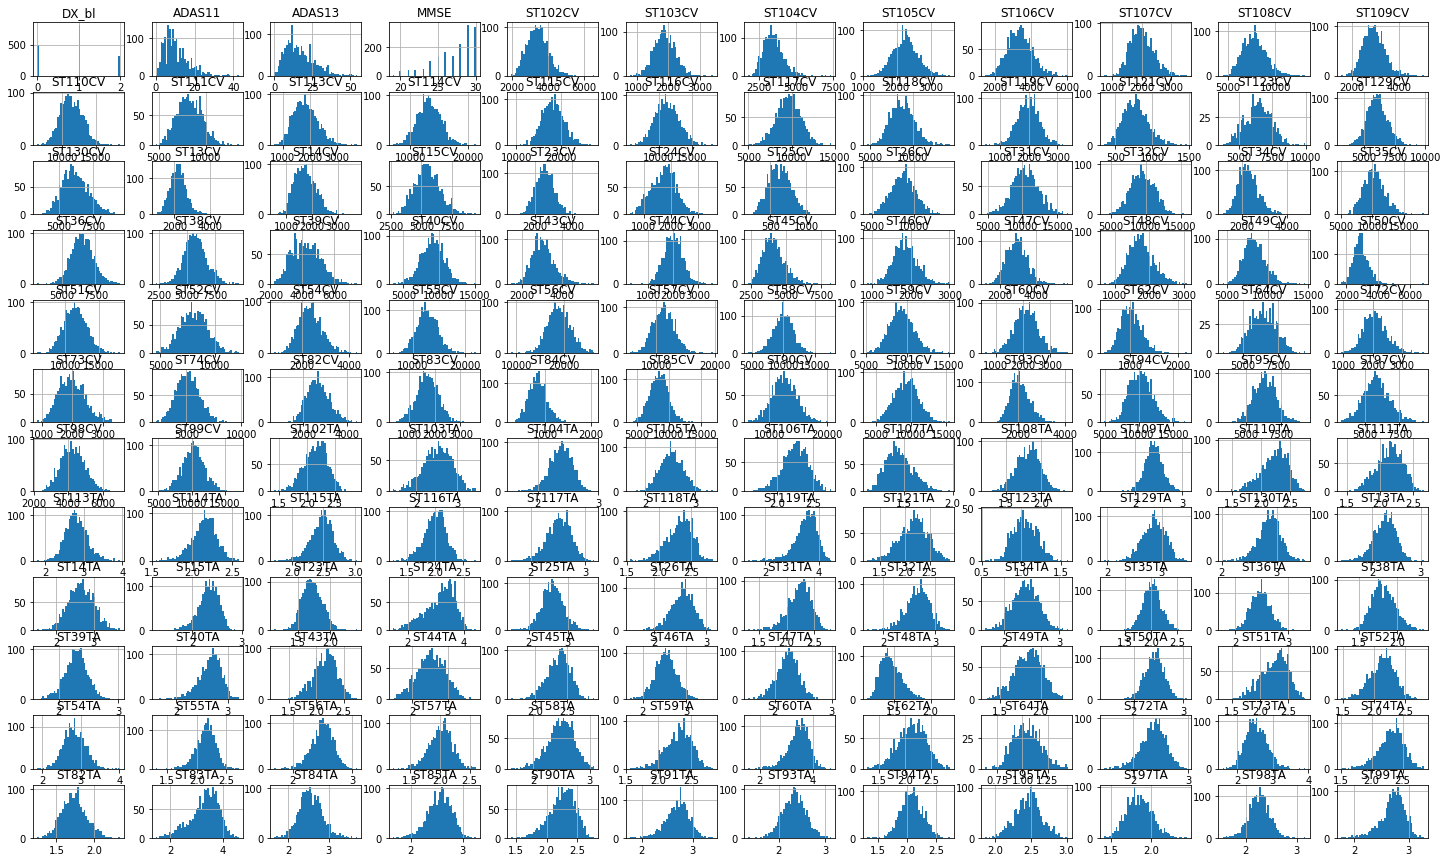

In [8]:
alzheimers_data.hist(bins=50, figsize=(25,15))
plt.show()

---

### **Normality Test**

In [9]:
alzheimers_data_columns = alzheimers_data.columns.tolist()

for i in alzheimers_data_columns:
  print('\n Column:', i, ', ', 'Length: ', alzheimers_data[i].notnull().sum(), '\n')
  print(normality_test(alzheimers_data[i]))


 Column: DX_bl ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 Column: ADAS11 ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 Column: ADAS13 ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
-----------

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the log(data) MAY NOT be drawn from a normal distribution
Try performing an outlier test.
None

 Column: ST26CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.05792. Therefore, the data was drawn from a normal distribution.
None

 Column: ST31CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.16249. Therefore, the data was drawn from a normal distribution.
None

 Column: ST32CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.35071. Therefore, the data was drawn from a normal distribution.
None

 Column: ST34CV ,  Length:  1607 

Using Shapiro-Wilky Test, the p-value is 0.0. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 0.52579. Therefore, the log(data) was drawn from a n

* Using the Shapiro-Wilkey test, majority of the attributes MAY NOT be drawn from a normal distribution. 

* I still don't know how to handle this, so I will just disregard this information in the meantime.

---

### **Creating a test set**

#### **Random Sampling**

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(alzheimers_data, test_size=0.2, random_state=42)

#### **Stratified Sampling**

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(alzheimers_data, alzheimers_data["DX_bl"]):
  strat_train_set = alzheimers_data.loc[train_index]
  strat_test_set = alzheimers_data.loc[test_index]

#### **Sampling Bias**

In [12]:
sampling_bias = pd.DataFrame({
    'Overall': [i for i in alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data)],
    'Stratified': [i for i in strat_test_set["DX_bl"].value_counts()/len(strat_test_set)],
    'Random': [i for i in test_set["DX_bl"].value_counts()/len(test_set)],
    'Strat % Error': [i for i in (alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data) - strat_test_set["DX_bl"].value_counts()/len(strat_test_set))*100],
    'Random % Error': [i for i in (alzheimers_data["DX_bl"].value_counts()/len(alzheimers_data) - test_set["DX_bl"].value_counts()/len(test_set))*100]

})

print('\n --Sampling Bias-- \n')
sampling_bias


 --Sampling Bias-- 



,Overall,Stratified,Random,Strat % Error,Random % Error
0,0.506534,0.506211,0.500000,0.032273,0.653391
1,0.301805,0.301242,0.285714,0.056237,1.609032
2,0.191661,0.192547,0.214286,-0.088510,-2.262423


* In the overall training dataset;
  1. **~50.7%** of the subjects are classified as **cognitively normal (Class = 0)**,
  2. **~30.2%** of the subjects are classified as having a **mild cognitive impairment (Class = 1)**,
  3. **~19.2%** of the subjects are classified as having **Alzheimer's disease (Class = 2)**.

* To mimic this distribution in the test set, **it is more reasonable to use the `strat_train_set` and `strat_test_set`.**

---

## **(02) Gaining insights from the data**

* First, I want to see how the other attributes are correlated with **DX_bl (diagnosis group)** attribute.

In [13]:
corr_matrix = alzheimers_data.corr()

pd.set_option("display.max_rows", None, "display.max_columns", None)
corr_matrix_diagnosis_df = pd.DataFrame({
    'Pearson Correlation Coefficient (Diagnosis Group)': corr_matrix["DX_bl"].sort_values(ascending=False)
})
corr_matrix_diagnosis_df

,Pearson Correlation Coefficient (Diagnosis Group)
DX_bl,1.000000
ADAS13,0.722164
ADAS11,0.682012
ST73CV,0.008397
ST14TA,-0.027894
ST23CV,-0.029479
ST43CV,-0.032474
ST14CV,-0.038665
ST82CV,-0.046000
ST73TA,-0.049506


* Attributes which have significant linear correlations with **DX_bl**:
  * **ADAS13**  : 0.72216     
  * **ADAS11**  : 0.682012
  * **ST40TA**  : -0.411479
  * **ST123TA** : -0.428103
  * **ST64TA**  : -0.429080
  * **ST83TA**  : -0.439323
  * **ST24TA**  : -0.465494
  * **MMSE**    : -0.723285

* It should be noted that a correlation value:
  * Almost equal to 1 means a positive linear correlation, i.e., as the independent variable increases, the dependent variable increases as well. **For this particular dataset, we can infer that the higher the scores in ADAS13 and ADAS11, the higher the probability that the subject is classified as having Alzheimer's disease;**
  * Equal to zero means no significant linear correlation; 
  * Almost equal to -1 means a negative linear correlation, i.e., as the independent variable increases, the dependent variable decreases. **For this particular dataset, we can infer that the lower the scores in MMSE, the higher the probability that the subject is classified as having Alzheimer's disease.**

* Also, it is interesting to note that **ST123TA**, **ST64TA**, **ST24TA** attributes have higher correlations with the **DX_bl (diagnosis group)** attribute. Hence, I cannot just simply discard these attributes.

* Let's look at the scatter plot of these attributes:

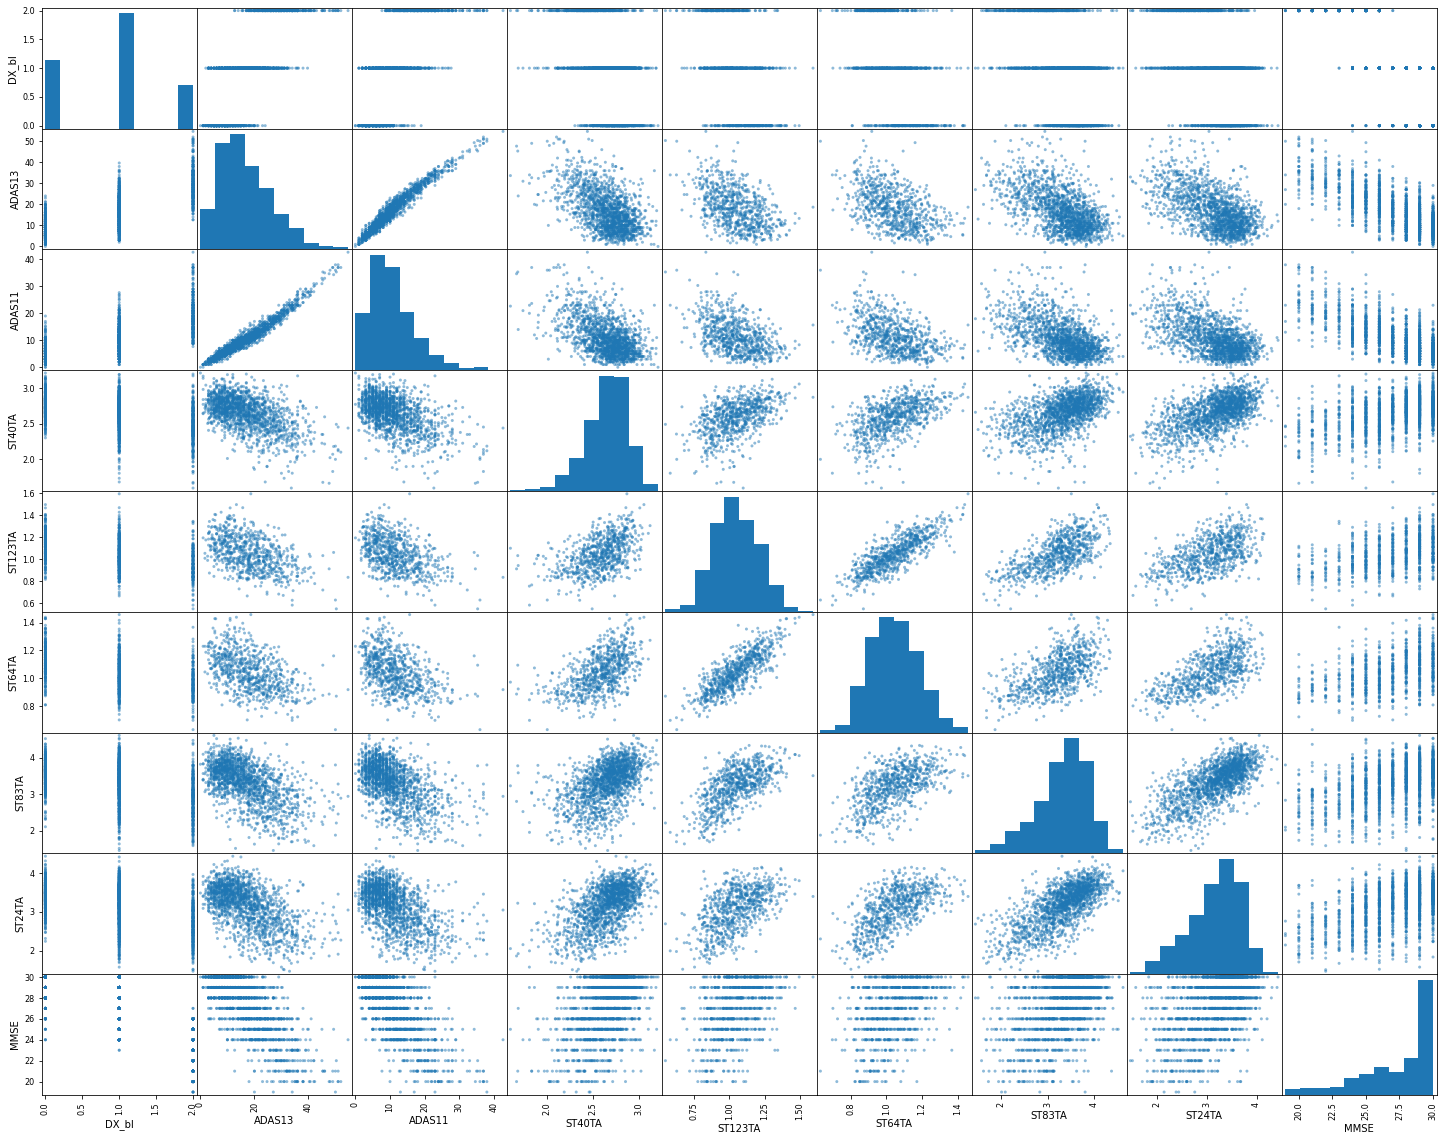

In [14]:
from pandas.plotting import scatter_matrix

attributes = ["DX_bl", "ADAS13", "ADAS11", "ST40TA", "ST123TA", "ST64TA", "ST83TA", "ST24TA", "MMSE"]
scatter_matrix(alzheimers_data[attributes], figsize=(25,20))
plt.show()

* From this scatter plot, it is easy to see that:
  * **ADAS11** and **ADAS13** have a visible positive correlation. 
  * **ST123TA** and **ST64TA** have an observable positive correlation as well.

## **(03) Preparing the data for ML algorithms**

#### **Separating features and labels**

In [15]:
# Features
alzheimers_data = strat_train_set.drop(["DX_bl", "ADAS11", "ADAS13", "MMSE"], axis=1)
print('\n --Shape of the feature matrix-- \n')
print(alzheimers_data.shape)

# Label for the classification task
alzheimers_data_classification_labels = strat_train_set["DX_bl"].copy()
print('\n --Shape of the classification label-- \n')
print(alzheimers_data_classification_labels.shape)

# Labels for the regression task
alzheimers_data_regression_labels = strat_train_set[["ADAS11", "ADAS13", "MMSE"]].copy()
print('\n --Shape of the regression labels-- \n')
print(alzheimers_data_regression_labels.shape)


 --Shape of the feature matrix-- 

(1285, 140)

 --Shape of the classification label-- 

(1285,)

 --Shape of the regression labels-- 

(1285, 3)


#### **Transformation Pipeline**

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', IterativeImputer(max_iter=1024, random_state=42)),
                         ('power_transformer', PowerTransformer(method='box-cox')),
                         #('scaler', StandardScaler())
])

In [18]:
from sklearn.compose import ColumnTransformer

import pandas as pd
num_attribs = list(alzheimers_data)

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs),
                                   
])

alzheimers_data_prepared = full_pipeline.fit_transform(alzheimers_data)
alzheimers_data_prepared_df = pd.DataFrame(alzheimers_data_prepared, columns=alzheimers_data.columns, index=alzheimers_data.index)

In [19]:
alzheimers_data_prepared_df.describe()

,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,ST43CV,ST44CV,ST45CV,ST46CV,ST47CV,ST48CV,ST49CV,ST50CV,ST51CV,ST52CV,ST54CV,ST55CV,ST56CV,ST57CV,ST58CV,ST59CV,ST60CV,ST62CV,ST64CV,ST72CV,ST73CV,ST74CV,ST82CV,ST83CV,ST84CV,ST85CV,ST90CV,ST91CV,ST93CV,ST94CV,ST95CV,ST97CV,ST98CV,ST99CV,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,ST113TA,ST114TA,ST115TA,ST116TA,ST117TA,ST118TA,ST119TA,ST121TA,ST123TA,ST129TA,ST130TA,ST13TA,ST14TA,ST15TA,ST23TA,ST24TA,ST25TA,ST26TA,ST31TA,ST32TA,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
count,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03,1.285000e+03
mean,-2.703587e-15,-2.642072e-16,1.743171e-14,-1.851524e-16,1.804523e-15,4.849558e-16,-6.977557e-15,-5.278268e-15,4.001123e-16,-1.180508e-15,2.882346e-15,-1.758991e-15,-4.552778e-16,-6.733049e-16,1.310182e-16,1.698900e-15,-4.687992e-16,-3.023954e-18,-7.551245e-17,2.023025e-15,1.677776e-15,-1.101238e-15,2.394107e-16,1.303756e-15,-4.568762e-16,-8.268138e-16,2.998034e-16,-6.437782e-16,-4.334622e-16,-7.556428e-16,-2.324708e-15,6.137681e-16,4.674601e-16,1.295937e-15,-4.995572e-16,-2.732358e-16,4.178607e-15,-1.289068e-16,3.302849e-15,9.253299e-17,3.010130e-16,5.768408e-16,-4.603894e-15,1.042625e-14,-2.108128e-16,-6.511004e-16,-5.758472e-16,5.394734e-16,1.000756e-15,4.271551e-16,9.691340e-16,8.714171e-16,1.459490e-16,-1.387217e-15,4.043458e-17,-1.409940e-15,-8.127956e-16,-5.434477e-16,-7.938311e-16,1.572456e-17,-7.275201e-16,1.114910e-15,2.643800e-16,6.701082e-16,1.875197e-15,-2.848564e-16,-2.596766e-16,5.770568e-16,3.085297e-16,1.741149e-16,3.093073e-17,1.000497e-16,-3.404108e-16,-1.036784e-17,3.085297e-16,2.181135e-16,-3.163920e-16,-1.324146e-15,2.298205e-17,-7.214722e-16,-2.463432e-15,2.493466e-16,-2.172063e-16,-7.749962e-17,3.002354e-16

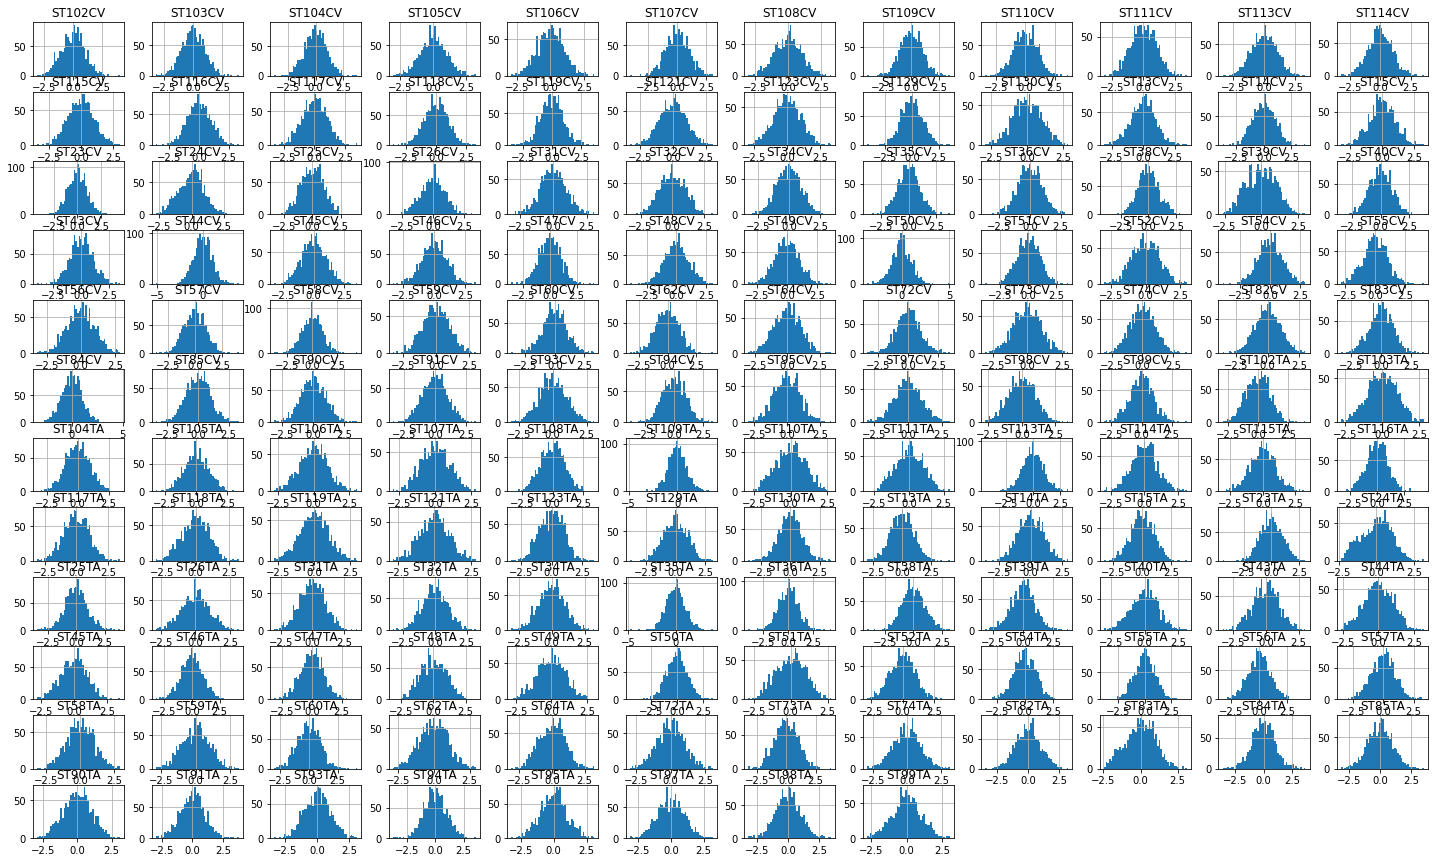

In [20]:
alzheimers_data_prepared_df.hist(bins=50, figsize=(25,15))
plt.show()

In [21]:
for i in alzheimers_data_columns[4:]:
  print('\n --{}-- \n'.format(i))
  print(normality_test(alzheimers_data_prepared_df[i]))


 --ST102CV-- 

Using Shapiro-Wilky Test, the p-value is 0.20032. Therefore, the data was drawn from a normal distribution.
None

 --ST103CV-- 

Using Shapiro-Wilky Test, the p-value is 0.76218. Therefore, the data was drawn from a normal distribution.
None

 --ST104CV-- 

Using Shapiro-Wilky Test, the p-value is 0.15124. Therefore, the data was drawn from a normal distribution.
None

 --ST105CV-- 

Using Shapiro-Wilky Test, the p-value is 0.79524. Therefore, the data was drawn from a normal distribution.
None

 --ST106CV-- 

Using Shapiro-Wilky Test, the p-value is 0.93194. Therefore, the data was drawn from a normal distribution.
None

 --ST107CV-- 

Using Shapiro-Wilky Test, the p-value is 0.67698. Therefore, the data was drawn from a normal distribution.
None

 --ST108CV-- 

Using Shapiro-Wilky Test, the p-value is 0.39979. Therefore, the data was drawn from a normal distribution.
None

 --ST109CV-- 

Using Shapiro-Wilky Test, the p-value is 0.43272. Therefore, the data was drawn f

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using Shapiro-Wilky Test, the p-value is 0.20693. Therefore, the data was drawn from a normal distribution.
None

 --ST40TA-- 

Using Shapiro-Wilky Test, the p-value is 0.48903. Therefore, the data was drawn from a normal distribution.
None

 --ST43TA-- 

Using Shapiro-Wilky Test, the p-value is 0.66523. Therefore, the data was drawn from a normal distribution.
None

 --ST44TA-- 

Using Shapiro-Wilky Test, the p-value is 0.01564. Therefore, the data MAY NOT be drawn from a normal distribution
----------------------------------------------------------------------------------------------------------------------------------
Testing for lognormality . . .
Using Shapiro-Wilky Test, the p-value is 1.0. Therefore, the log(data) was drawn from a normal distribution.
None

 --ST45TA-- 

Using Shapiro-Wilky Test, the p-value is 0.17037. Therefore, the data was drawn from a normal distribution.
None

 --ST46TA-- 

Using Shapiro-Wilky Test, the p-value is 0.4361. Therefore, the data was drawn from

* Now, we can see that majority of the features have a normal-like distribution.
  * The next step is training different classification models.

## **(04) Training different classification models**

#### **(0.1) Preliminary Evaluation of ML Classification Models**

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier



models = []
models.append(('Dummy', DummyClassifier(strategy='prior')))
models.append(('SGD', SGDClassifier()))
models.append(('Forest', RandomForestClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('SVM (OvR)', OneVsRestClassifier(SVC(gamma='auto'))))
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))

names = []
scores = []


for name, model in models:
  kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  cv_scores = cross_val_score(model, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=kfold, scoring="accuracy")
  scores.append(cv_scores)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_scores.mean(), cv_scores.std()))

Dummy: 0.506619 (0.002496)
SGD: 0.464638 (0.035552)
Forest: 0.550951 (0.047283)
NB: 0.447450 (0.023541)
SVM (OvR): 0.532243 (0.046711)
LR: 0.515177 (0.031900)
DecisionTree: 0.468393 (0.037494)
KNN: 0.477889 (0.040813)
LDA: 0.533830 (0.034480)
QDA: 0.496524 (0.021064)
GradientBoostingClassifier: 0.535459 (0.039452)


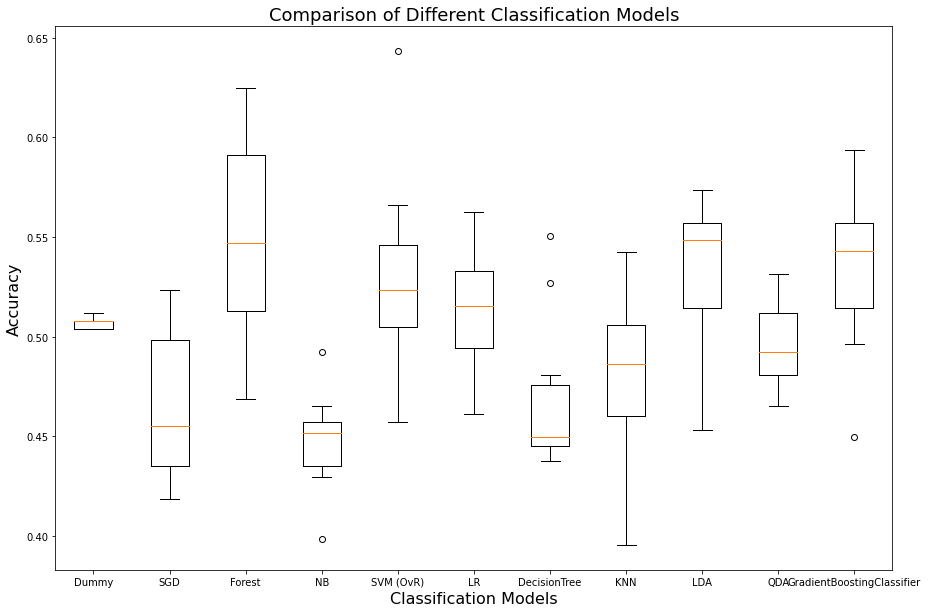

In [26]:
plt.figure(figsize=(15,10))
plt.boxplot(scores, labels=names)
plt.title('Comparison of Different Classification Models', fontsize=18)
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

* Usung a stratified 10-fold cross validation, **a dummy classifier has achieved an accuracy of about 0.51**. This will be the basis for the selection of several promising classifier models.

* From this accuracy-based evaluation, the promising models are
  * `RandomForestClassifier`
  * `GradientBoostingClassifier`: I have opted to exclude this in my analysis
  * `LinearDiscriminantAnalysis`
  * `OneVsRestClassifier(SVC)`

* It should be noted though that the accuracy of these classification models are still bad since they are only slightly better than the (random) dummy classifier. For now though, I will focus my attention on these models.

### **(0.2) Dummy Random Classifier**

In [27]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

DummyClassifier(constant=None, random_state=None, strategy='prior')

#### Cross-validation

In [28]:
from sklearn.model_selection import cross_val_score

dummy_cv_score = cross_val_score(dummy_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="accuracy")
print(dummy_cv_score)

[0.51162791 0.50387597 0.50387597 0.50387597 0.50387597 0.5078125
 0.5078125  0.5078125  0.5078125  0.5078125 ]


#### **Precision/Recall and ROC AUC Scores**

In [29]:
dummy_classes_ = []
dummy_precision_scores_ = []
dummy_recall_scores_ = []
dummy_roc_auc_scores_ = []
dummy_fpr_ = {}
dummy_tpr_ = {}

dummy_classes_, dummy_precision_scores_, dummy_recall_scores_, dummy_roc_auc_scores_, dummy_fpr_, dummy_tpr_ = precision_recall_auc_scores(dummy_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, dummy_classes_, dummy_precision_scores_, dummy_recall_scores_, dummy_roc_auc_scores_, dummy_fpr_, dummy_tpr_, random_=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [30]:
dummy_precision_recall_table = pd.DataFrame({
    "Class": dummy_classes_,
    "Precision Score": dummy_precision_scores_,
    "Recall Score": dummy_recall_scores_,
    "ROC AUC Score": dummy_roc_auc_scores_
})
dummy_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.000000,0.000000,0.5
1,1,0.506615,0.506615,0.5
2,2,0.000000,0.000000,0.5


#### **ROC Curve**

Text(0.5, 1.0, 'ROC Curve (DummyClassifier)')

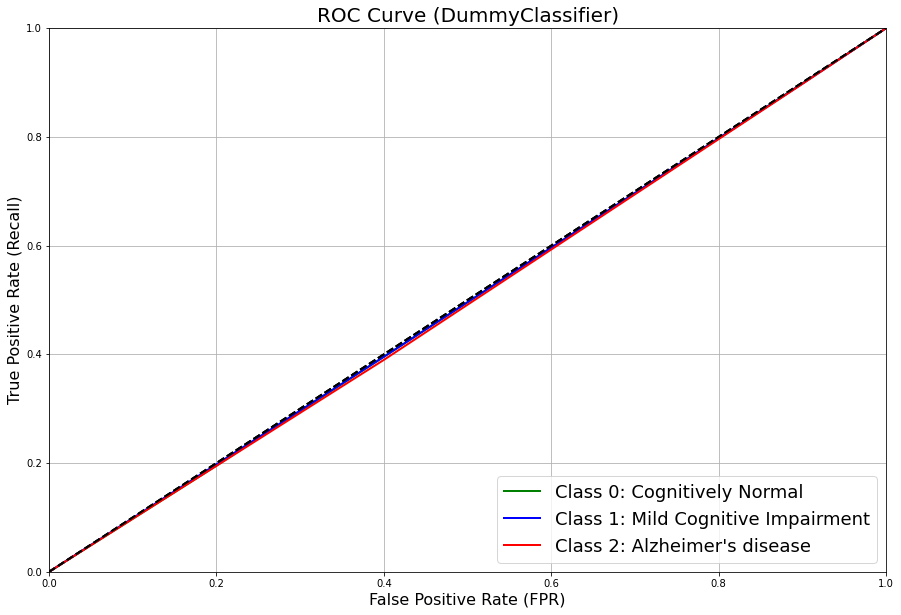

In [31]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(dummy_fpr_[0], dummy_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(dummy_fpr_[1], dummy_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(dummy_fpr_[2], dummy_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (DummyClassifier)', fontsize=20)

### **(a) Random Forest Classifiers**

In [32]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### **Cross-validation**

In [33]:
forest_cv_score = cross_val_score(forest_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="accuracy")
print(forest_cv_score)

[0.51937984 0.48062016 0.51937984 0.54263566 0.54263566 0.609375
 0.53125    0.515625   0.5859375  0.5625    ]


#### **Feature Importance**

Feature: 0, Score: 0.00732
Feature: 1, Score: 0.00560
Feature: 2, Score: 0.00512
Feature: 3, Score: 0.00655
Feature: 4, Score: 0.00490
Feature: 5, Score: 0.00581
Feature: 6, Score: 0.00658
Feature: 7, Score: 0.00534
Feature: 8, Score: 0.00494
Feature: 9, Score: 0.00717
Feature: 10, Score: 0.00729
Feature: 11, Score: 0.00547
Feature: 12, Score: 0.00488
Feature: 13, Score: 0.00508
Feature: 14, Score: 0.00564
Feature: 15, Score: 0.00660
Feature: 16, Score: 0.00670
Feature: 17, Score: 0.00641
Feature: 18, Score: 0.01172
Feature: 19, Score: 0.00497
Feature: 20, Score: 0.00549
Feature: 21, Score: 0.00510
Feature: 22, Score: 0.00653
Feature: 23, Score: 0.00611
Feature: 24, Score: 0.00699
Feature: 25, Score: 0.01729
Feature: 26, Score: 0.00585
Feature: 27, Score: 0.00755
Feature: 28, Score: 0.00863
Feature: 29, Score: 0.00886
Feature: 30, Score: 0.00664
Feature: 31, Score: 0.00775
Feature: 32, Score: 0.00524
Feature: 33, Score: 0.00603
Feature: 34, Score: 0.00588
Feature: 35, Score: 0.00663
Fe

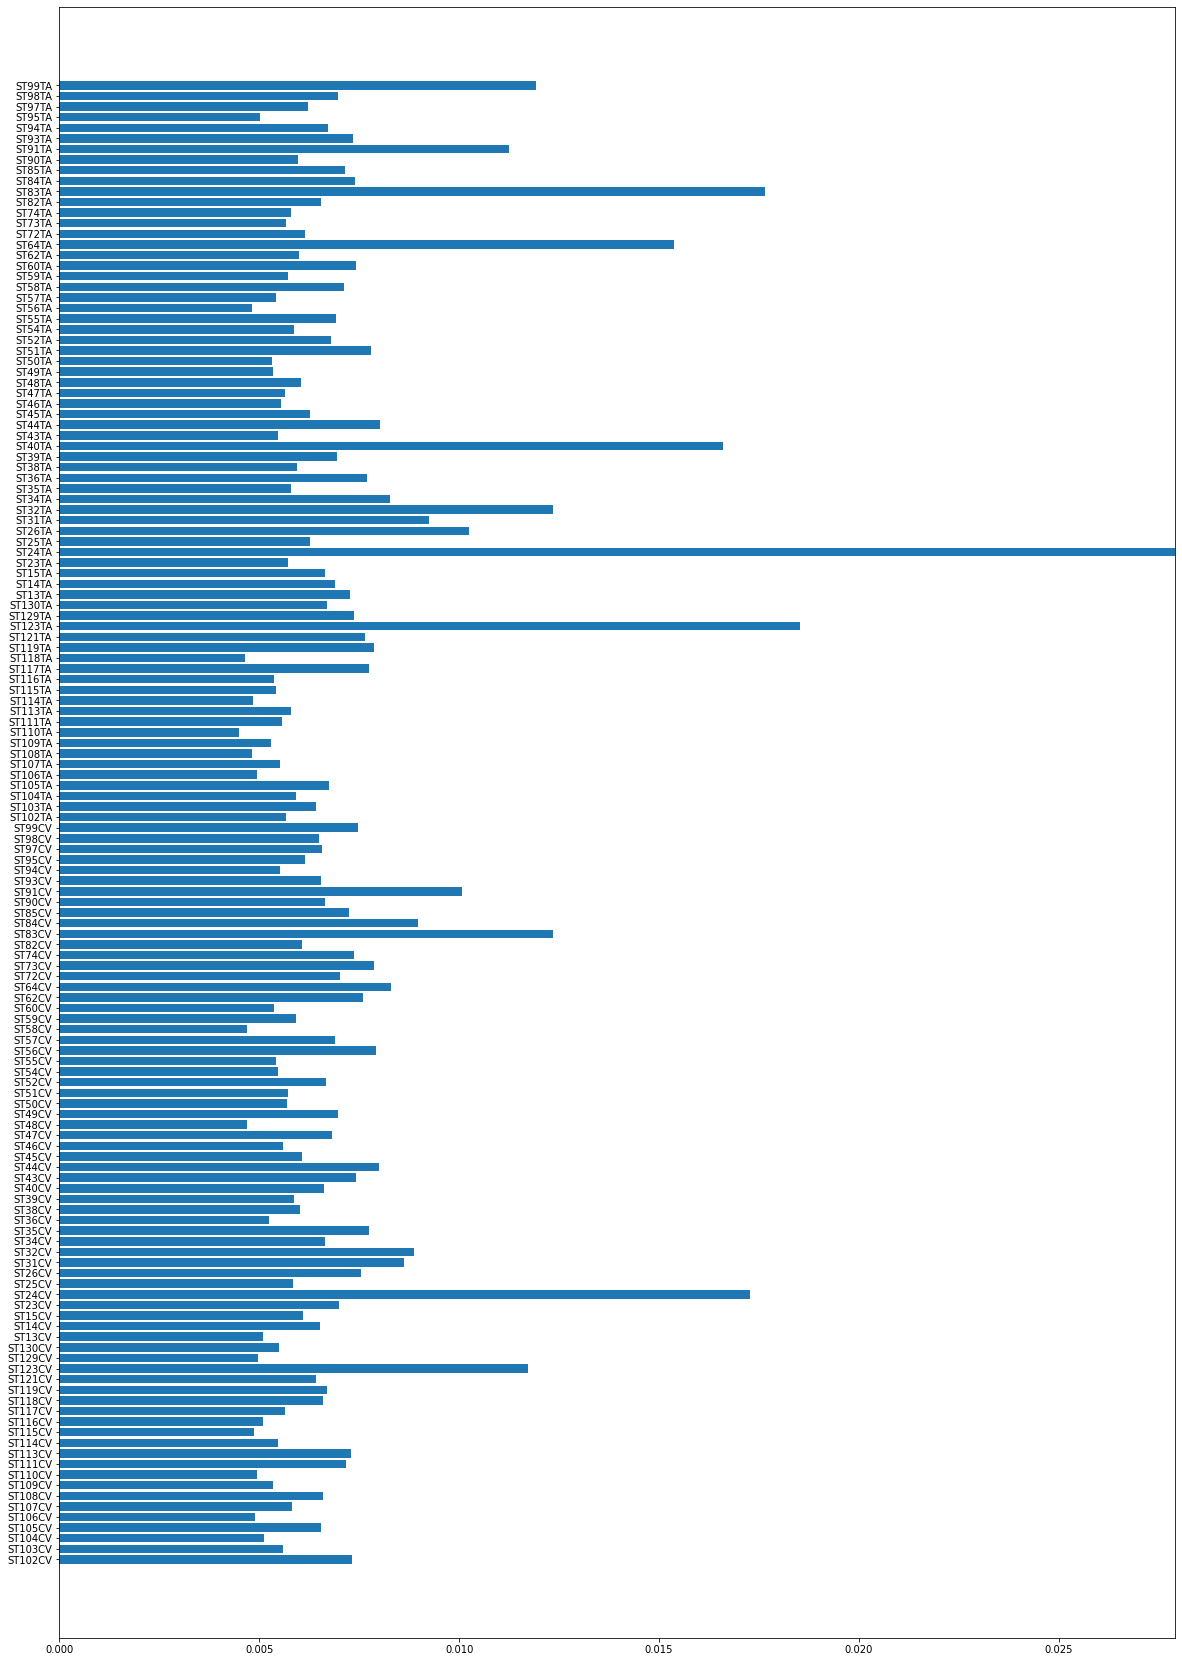

In [34]:
from sklearn.datasets import make_classification

importance = forest_clf.feature_importances_

# Summary of Feature Importance
for i, v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i, v))

# Plot of Feature Importance
print('\n')
plt.figure(figsize=(20,30))
plt.barh([column for column in alzheimers_data_prepared_df.columns.to_list()], importance, align='center')
plt.xlim([0, np.max(importance)])
plt.show()

* Majority of the features have relatively the same importance weights, except for **ST24TA**, which has an outstanding importance weight.

#### **Precision/Recall and ROC AUC Scores**

In [35]:
forest_classes_ = []
forest_precision_scores_ = []
forest_recall_scores_ = []
forest_roc_auc_scores_ = []
forest_fpr_ = {}
forest_tpr_ = {}

forest_classes_, forest_precision_scores_, forest_recall_scores_, forest_roc_auc_scores_, forest_fpr_, forest_tpr_ = precision_recall_auc_scores(forest_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, forest_classes_, forest_precision_scores_, forest_recall_scores_, forest_roc_auc_scores_, forest_fpr_, forest_tpr_, random_=True)

In [36]:
forest_precision_recall_table = pd.DataFrame({
    "Class": forest_classes_,
    "Precision Score": forest_precision_scores_,
    "Recall Score": forest_recall_scores_,
    "ROC AUC Score": forest_roc_auc_scores_
})
forest_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.485294,0.485294,0.546033
1,1,0.510236,0.510236,0.503580
2,2,0.637097,0.637097,0.638914


#### **ROC Curves (OvR Implementation)**

Text(0.5, 1.0, 'ROC Curve (RandomForestClassifier)')

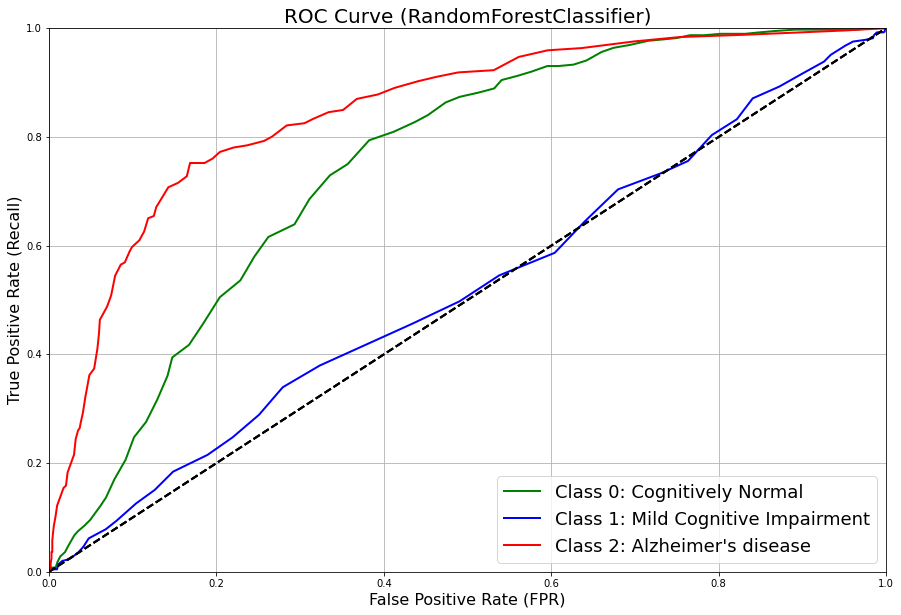

In [37]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(forest_fpr_[0], forest_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(forest_fpr_[1], forest_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(forest_fpr_[2], forest_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (RandomForestClassifier)', fontsize=20)

### **(b) Gradient Boosting Classifier**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_clf = GradientBoostingClassifier(random_state=42)
grad_boost_clf.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### **Cross-validation score**

In [39]:
grad_boost_clf_cv_score = cross_val_score(grad_boost_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="accuracy")
print(grad_boost_clf_cv_score)

[0.44186047 0.52713178 0.51162791 0.54263566 0.56589147 0.59375
 0.5390625  0.5625     0.609375   0.6015625 ]


#### **Precision/Recall and ROC AUC scores**

In [40]:
grad_boost_classes_ = []
grad_boost_precision_scores_ = []
grad_boost_recall_scores_ = []
grad_boost_roc_auc_scores_ = []
grad_boost_fpr_ = {}
grad_boost_tpr_ = {}

grad_boost_classes_, grad_boost_precision_scores_, grad_boost_recall_scores_, grad_boost_roc_auc_scores_, grad_boost_fpr_, grad_boost_tpr_ = precision_recall_auc_scores(grad_boost_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, grad_boost_classes_, grad_boost_precision_scores_, grad_boost_recall_scores_, grad_boost_roc_auc_scores_, grad_boost_fpr_, grad_boost_tpr_, random_=True)

In [42]:
grad_boost_precision_recall_table = pd.DataFrame({
    "Class": grad_boost_classes_,
    "Precision Score": grad_boost_precision_scores_,
    "Recall Score": grad_boost_recall_scores_,
    "ROC AUC Score": grad_boost_roc_auc_scores_
})
grad_boost_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.501961,0.501961,0.594157
1,1,0.525399,0.525399,0.520147
2,2,0.643312,0.643312,0.678336


#### **ROC Curves (OvR Implementation)**

Text(0.5, 1.0, 'ROC Curve (GradientBoostingClassifier)')

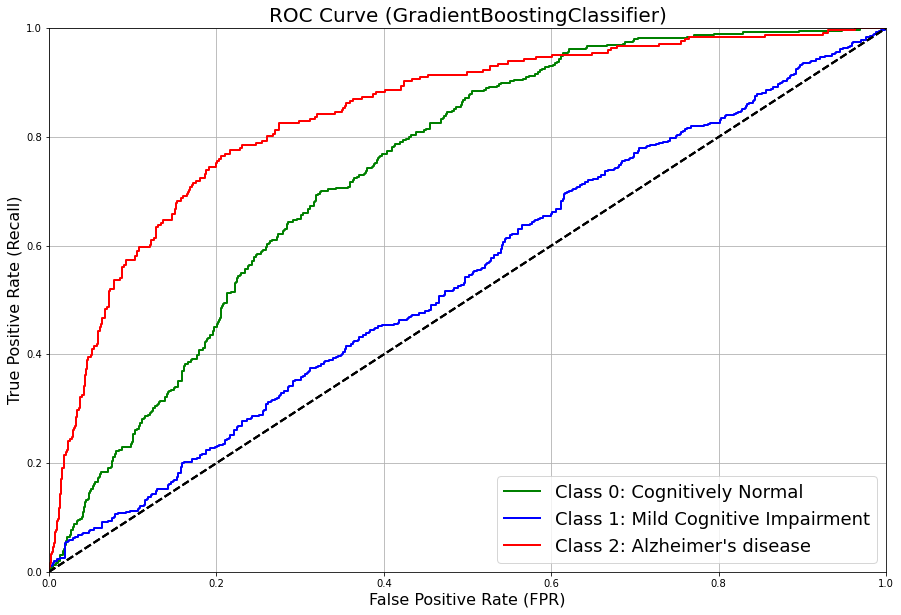

In [44]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(grad_boost_fpr_[0], grad_boost_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(grad_boost_fpr_[1], grad_boost_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(grad_boost_fpr_[2], grad_boost_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (GradientBoostingClassifier)', fontsize=20)

### **(c) Linear Discriminant Analysis**

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

#### **Cross-validation score**

In [72]:
lda_clf_cv_score = cross_val_score(lda_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="accuracy")
print(lda_clf_cv_score)

[0.59689922 0.52713178 0.60465116 0.46511628 0.57364341 0.5625
 0.5078125  0.53125    0.5625     0.5703125 ]


#### **Precision/Recall and ROC AUC scores**

In [73]:
lda_classes_ = []
lda_precision_scores_ = []
lda_recall_scores_ = []
lda_roc_auc_scores_ = []
lda_fpr_ = {}
lda_tpr_ = {}

lda_classes_, lda_precision_scores_, lda_recall_scores_, lda_roc_auc_scores_, lda_fpr_, lda_tpr_ = precision_recall_auc_scores(lda_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, lda_classes_, lda_precision_scores_, lda_recall_scores_, lda_roc_auc_scores_, lda_fpr_, lda_tpr_, random_=True)

In [74]:
lda_precision_recall_table = pd.DataFrame({
    "Class": lda_classes_,
    "Precision Score": lda_precision_scores_,
    "Recall Score": lda_recall_scores_,
    "ROC AUC Score": lda_roc_auc_scores_
})
lda_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.493421,0.493421,0.607457
1,1,0.533026,0.533026,0.526765
2,2,0.606635,0.606635,0.720220


#### **ROC Curves (OvR Implementation)**

Text(0.5, 1.0, 'ROC Curve (LinearDiscrimninantAnalysis)')

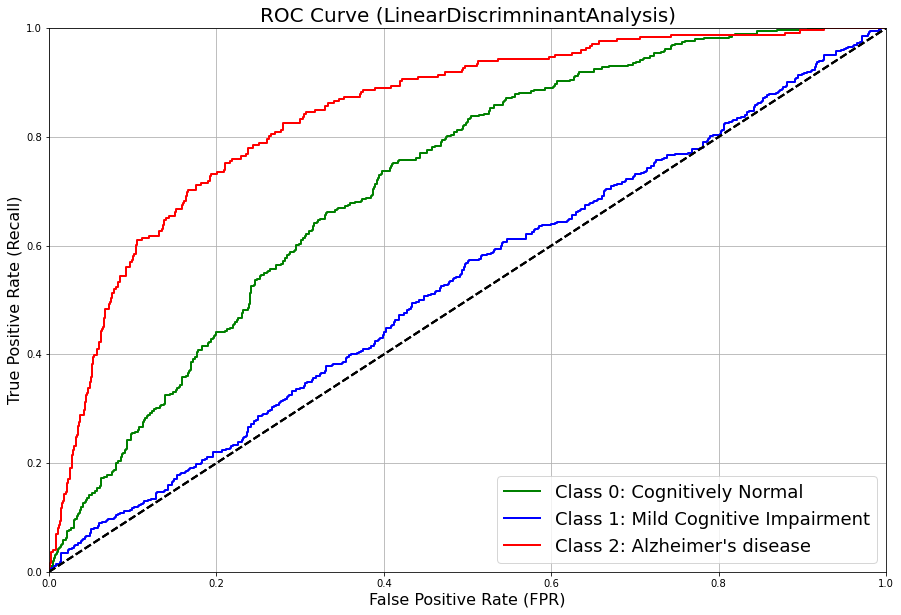

In [75]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(lda_fpr_[0], lda_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(lda_fpr_[1], lda_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(lda_fpr_[2], lda_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (LinearDiscrimninantAnalysis)', fontsize=20)

### (d) Support Vector Machine (OvR)

In [51]:
svm_clf = OneVsRestClassifier(SVC(gamma='auto'))
svm_clf.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

#### **Cross-validation Score**

In [53]:
svm_clf_cv_score = cross_val_score(svm_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="accuracy")
print(svm_clf_cv_score)

[0.50387597 0.52713178 0.46511628 0.58139535 0.56589147 0.5625
 0.5        0.53125    0.5703125  0.546875  ]


#### **Precision/Recall and ROC AUC Scores**

In [55]:
svm_classes_ = []
svm_precision_scores_ = []
svm_recall_scores_ = []
svm_roc_auc_scores_ = []
svm_fpr_ = {}
svm_tpr_ = {}

svm_classes_, svm_precision_scores_, svm_recall_scores_, svm_roc_auc_scores_, svm_fpr_, svm_tpr_ = precision_recall_auc_scores(svm_clf, alzheimers_data_prepared, alzheimers_data_classification_labels, svm_classes_, svm_precision_scores_, svm_recall_scores_, svm_roc_auc_scores_, svm_fpr_, svm_tpr_, random_=False)

In [56]:
svm_precision_recall_table = pd.DataFrame({
    "Class": svm_classes_,
    "Precision Score": svm_precision_scores_,
    "Recall Score": svm_recall_scores_,
    "ROC AUC Score": svm_roc_auc_scores_
})
svm_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.500000,0.500000,0.558500
1,1,0.544267,0.544267,0.540384
2,2,0.644928,0.644928,0.657314


#### **ROC Curves (OvR Implementation)**

Text(0.5, 1.0, 'ROC Curve (Support Vector Machine [OvR])')

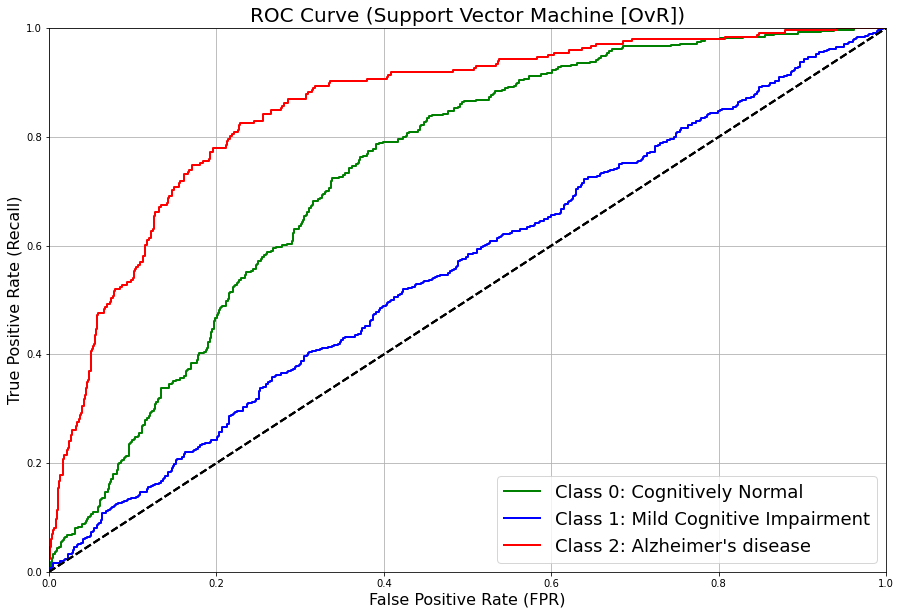

In [57]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(svm_fpr_[0], svm_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(svm_fpr_[1], svm_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(svm_fpr_[2], svm_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (Support Vector Machine [OvR])', fontsize=20)

### **(e) Evaluation**

* Although `RandomForestClassifier` has the best accuracy score, but `LinearDiscriminantAnalysis` has the best ROC AUC score. So, I have opted to use it as my best model.

## **(05) Fine-tuning Linear Discriminant Analysis**

In [86]:
solver = ['svd', 'lsqr', 'eigen']
shrinkage = [None, 'auto', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tol = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

param_grid_ = dict(
    solver = solver,
    shrinkage = shrinkage,
    tol = tol
)

lda_grid_search = GridSearchCV(lda_clf, param_grid=param_grid_, scoring='roc_auc_ovr', cv=cv, verbose=4, n_jobs=-1)

In [87]:
lda_search_result = lda_grid_search.fit(alzheimers_data_prepared, alzheimers_data_classification_labels)

Fitting 50 folds for each of 195 candidates, totalling 9750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1444 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5962 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8942 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9750 out of 9750 | elapsed:  3.2min finished


#### **Defining my best classifier**

In [92]:
myBest_classifier = lda_search_result.best_estimator_
dump(myBest_classifier, 'myBest_classifier.pkl')

['myBest_classifier.pkl']

##### **Cross-validation Score**

In [93]:
cross_val_score(myBest_classifier, alzheimers_data_prepared, alzheimers_data_classification_labels, cv=10, scoring="roc_auc_ovr", n_jobs=-1)

array([0.75249338, 0.733217  , 0.73142035, 0.68978989, 0.77061847,
       0.74337301, 0.71005697, 0.73467338, 0.77315164, 0.74210317])

##### **Precision/Recall and ROC AUC scores**

In [100]:
best_classes_ = []
best_precision_scores_ = []
best_recall_scores_ = []
best_roc_auc_scores_ = []
best_fpr_ = {}
best_tpr_ = {}

best_classes_, best_precision_scores_, best_recall_scores_, best_roc_auc_scores_, best_fpr_, best_tpr_ = precision_recall_auc_scores(myBest_classifier, alzheimers_data_prepared, alzheimers_data_classification_labels, best_classes_, best_precision_scores_, best_recall_scores_, best_roc_auc_scores_, best_fpr_, best_tpr_, random_=False)

In [102]:
best_precision_recall_table = pd.DataFrame({
    "Class": best_classes_,
    "Precision Score": best_precision_scores_,
    "Recall Score": best_recall_scores_,
    "ROC AUC Score": best_roc_auc_scores_
})
best_precision_recall_table

,Class,Precision Score,Recall Score,ROC AUC Score
0,0,0.489736,0.489736,0.618216
1,1,0.533333,0.533333,0.528075
2,2,0.587549,0.587549,0.755900


* Not bad. The smallest ROC AUC score is for class 1 which is about 0.53.

##### **ROC Curves (OvR Implementation)**

Text(0.5, 1.0, 'ROC Curve (Fine-tuned Linear Discriminant Analysis)')

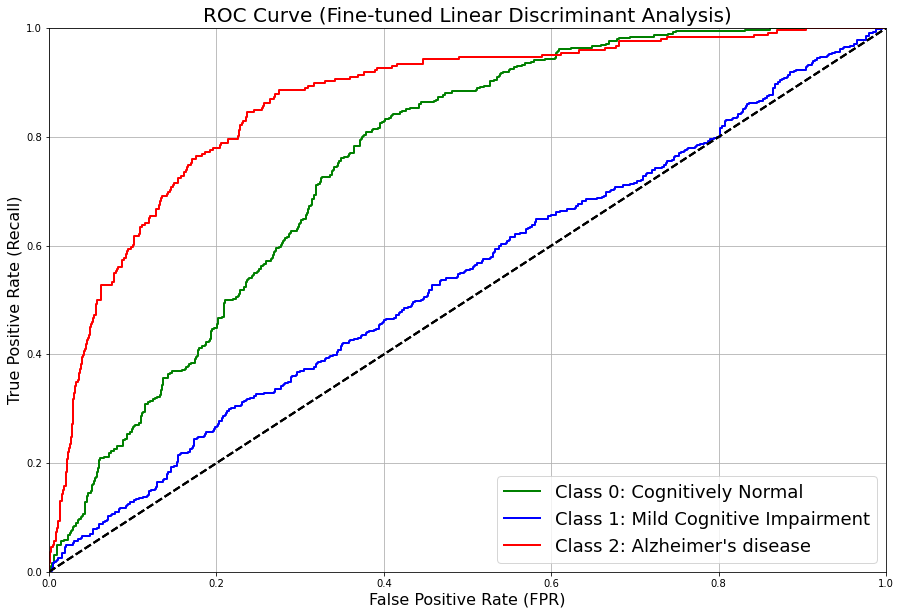

In [103]:
plt.figure(figsize=(15,10))
plot_roc_curves_ovr(best_fpr_[0], best_tpr_[0], "g-", "Class 0: Cognitively Normal")
plot_roc_curves_ovr(best_fpr_[1], best_tpr_[1], "b-", "Class 1: Mild Cognitive Impairment")
plot_roc_curves_ovr(best_fpr_[2], best_tpr_[2], "r-", "Class 2: Alzheimer's disease")
plt.legend(loc="lower right", fontsize=18)
plt.title('ROC Curve (Fine-tuned Linear Discriminant Analysis)', fontsize=20)

## **(06) Constructing a full pipeline with both preparation and classifier**

In [96]:
full_pipeline_with_classifier = Pipeline([
                                          ("preparation", full_pipeline),
                                          ("best_classifier", myBest_classifier)
])

### **Model persistence using joblib**

In [97]:
myBest_classifier_model = full_pipeline_with_classifier

dump(myBest_classifier_model, 'myBest_classifier_model.pkl')

['myBest_classifier_model.pkl']

## **(07) Evaluating on the test set**

### **Separating features and labels**

In [104]:
# Features
alzheimers_test_data = strat_test_set.drop(["DX_bl", "ADAS11", "ADAS13", "MMSE"], axis=1)
print('\n --Shape of the feature matrix-- \n')
print(alzheimers_test_data.shape)

# Label for the classification task
alzheimers_test_data_classification_labels = strat_test_set["DX_bl"].copy()
print('\n --Shape of the classification label-- \n')
print(alzheimers_test_data_classification_labels.shape)

# Labels for the regression task
alzheimers_test_data_regression_labels = strat_test_set[["ADAS11", "ADAS13", "MMSE"]].copy()
print('\n --Shape of the regression labels-- \n')
print(alzheimers_test_data_regression_labels.shape)


 --Shape of the feature matrix-- 

(322, 140)

 --Shape of the classification label-- 

(322,)

 --Shape of the regression labels-- 

(322, 3)


In [119]:
alzheimers_test_data_classification_pred =  myBest_classifier_model.predict(alzheimers_test_data)
print(alzheimers_test_data_classification_pred)

[1 1 1 1 1 1 0 1 1 1 1 2 0 2 1 0 1 2 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 1 1 2 2 1 0 0 1 1 0 2 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 2 1 1 0 1 1 1 0 1 2 1 1 2 0 1 2 0 0 2 0 1 1 2 0 2 0 0 1 2 1 1 1 1 1 1 0
 2 1 2 0 1 2 1 1 0 1 2 2 1 1 2 1 2 2 0 1 1 2 1 1 0 2 0 0 1 0 1 1 1 1 1 1 0
 0 0 1 0 1 1 1 1 1 1 2 1 1 0 1 0 1 1 2 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 2 1
 2 2 2 1 2 1 1 1 1 2 1 1 1 1 1 0 0 2 1 2 1 0 1 2 0 1 1 1 1 2 0 1 2 1 2 1 1
 1 1 1 0 0 1 0 1 1 1 1 1 0 2 1 1 1 1 2 1 2 1 0 0 0 2 0 2 1 0 1 1 1 1 1 1 0
 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 2 2 1 1 2 2 1 1 1 0 0 1 1 2 1 1 1 2 0 1 0
 1 1 0 1 1 0 1 0 1 2 2 1 1 1 2 0 1 1 1 1 1 1 0 2 1 2]


### **ROC AUC scores (OvR Implementation)**

In [131]:
from sklearn.metrics import roc_auc_score

test_roc_auc_scores = {0: [], 1: [], 2:[]}
for class_ in myBest_classifier_model.classes_:
  test_roc_auc_scores[class_] = [roc_auc_score(alzheimers_test_data_classification_labels==class_, alzheimers_test_data_classification_pred==class_)]
  print('ROC AUC score of class {} is {}'.format(class_, roc_auc_score(alzheimers_test_data_classification_labels==class_, alzheimers_test_data_classification_pred==class_)))

print('\n --ROC AUC Scores of the test set-- \n')

test_roc_auc_scores_df = pd.DataFrame(
    test_roc_auc_scores,
    index = ['ROC AUC Score']    
)
test_roc_auc_scores_df

ROC AUC score of class 0 is 0.6313402061855671
ROC AUC score of class 1 is 0.5392213604969711
ROC AUC score of class 2 is 0.665818858560794

 --ROC AUC Scores of the test set-- 



,0,1,2
ROC AUC Score,0.63134,0.539221,0.665819


* Again, not bad. **The ROC AUC score for each class is above 0.53, which is slightly higher than the unskilled dummy classifier**.

## **(08) Conclusion and Takeaway**

* For this particular dataset, I have found that the best performing classifier in terms of the ROC AUC score is the `LinearDiscriminantAnalysis` classifier.

* When used on the test set, this classifier has acieved an ROC AUC score of above ~0.54 for each class. Although not optimal, yet this is slighty better than an unskilled dummy classifier.

* Due to time constraints, I have not further explored ways to process the dataset. But in the future, these could be the possible ways to improve the model's ROC AUC scores:
  * Outlier detection and removal, and
  * Features' importance selection.

* This is the significant inference that I have taken from this dataset:
  * Subjects with small (or should I say reduced) cortical volumes and average thicknesses in their 70 brain regions may be classified as having Alzheimer's disease.

* **Although beyond the scope of this project, yet these are the interesting points which could be learned from this dataset**:
  1. If there are shrinkages in specific regions of the brain, what are these regions that we should be looking at for a patient to be classified as having Alzheimer's disease?
  2. Much challenging questions:
    * What is the percentage of shrinkage in that specific region should be for a patient to be classified as having Alzheimer's disease? This is difficult becauase this requires a long-term observation. The patients should be observed when they are still cognitively normal.
    * What leads to the shrinkage in these regions?
